## Importing Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score,mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
x_full = pd.read_csv("Train_Data.csv")
X_test_full = pd.read_csv("Test_Data.csv")
x_full.head()

,date,campaign,adgroup,ad,impressions,clicks,cost,conversions,revenue
0,01-08-2020,campaign 1,adgroup 1,ad 1,24,6,0.08,0,0.00
1,01-08-2020,campaign 1,adgroup 2,ad 1,1,0,0.00,0,0.00
2,01-08-2020,campaign 1,adgroup 3,ad 1,13,4,0.04,0,0.00
3,01-08-2020,campaign 1,adgroup 4,ad 1,5,4,0.08,0,0.00
4,01-08-2020,campaign 1,adgroup 1,ad 2,247,126,1.29,4,925.71


## Visualization :

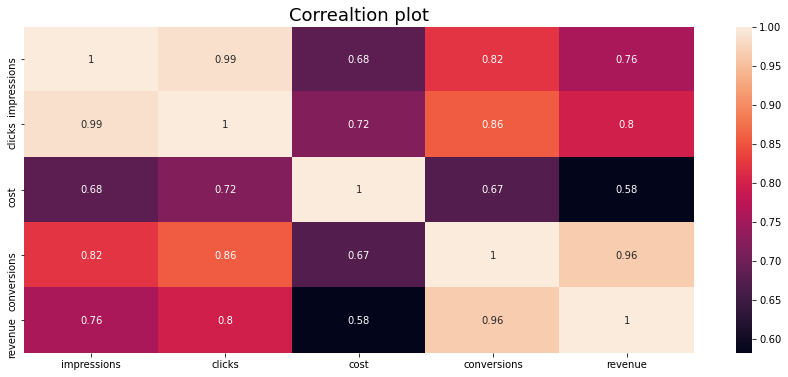

In [3]:
fig = plt.figure(figsize=(15,6))
sns.heatmap(x_full.corr(),annot=True)
plt.title("Correaltion plot",size=18);

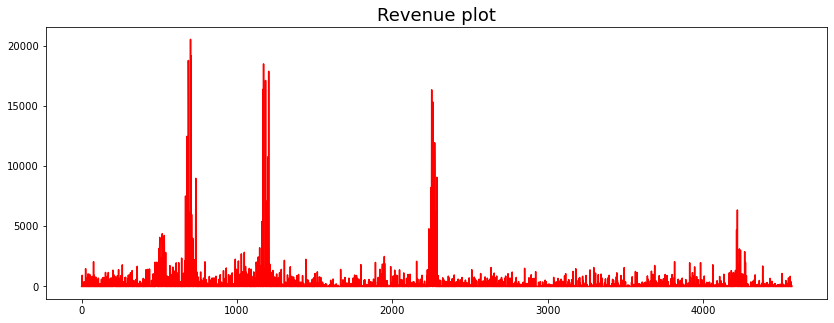

In [4]:
# revenue plot shows there are several spikes and there is no linearity in the data
plt.figure(figsize=(14,5))
plt.tight_layout()
plt.plot(x_full['revenue'],color='red')
plt.title("Revenue plot",size=18);

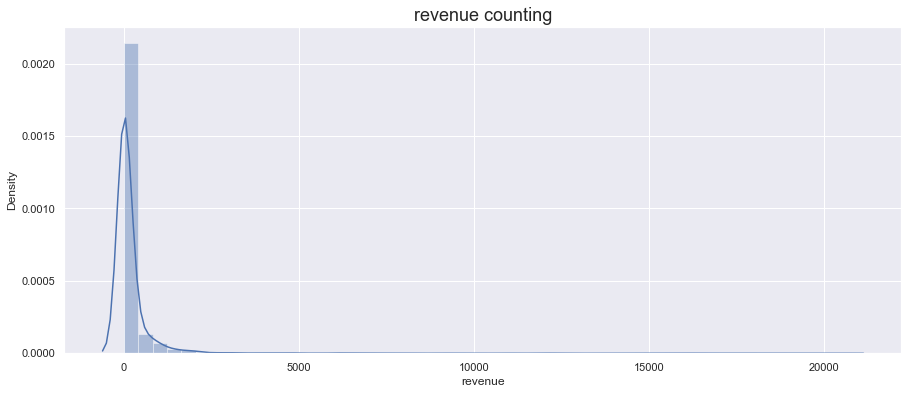

In [5]:
sns.set()
fig = plt.figure(figsize=(15,6))
sns.distplot(x_full.revenue)
plt.title("revenue counting",size=18);

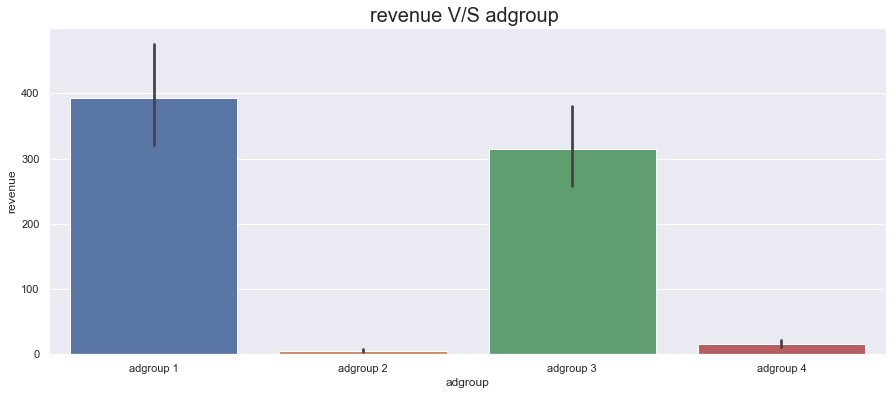

In [6]:
fig = plt.figure(figsize=(15,6))
sns.barplot(x='adgroup', y='revenue', data= x_full)
plt.title("revenue V/S adgroup ",size=20);

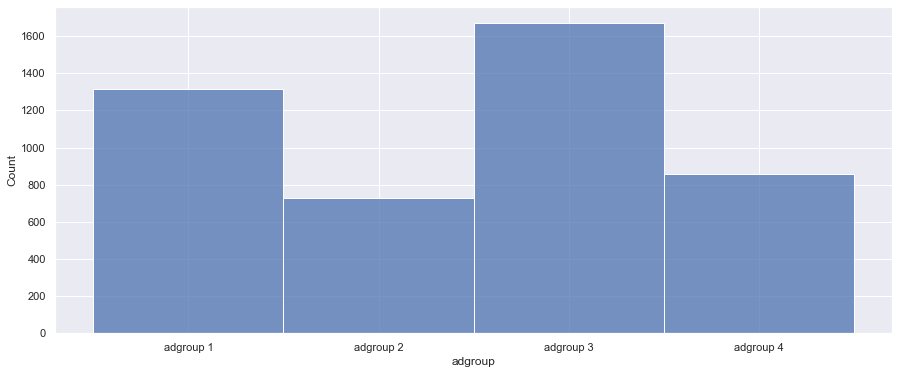

In [7]:
fig = plt.figure(figsize=(15,6))
sns.histplot(x='adgroup', data= x_full);

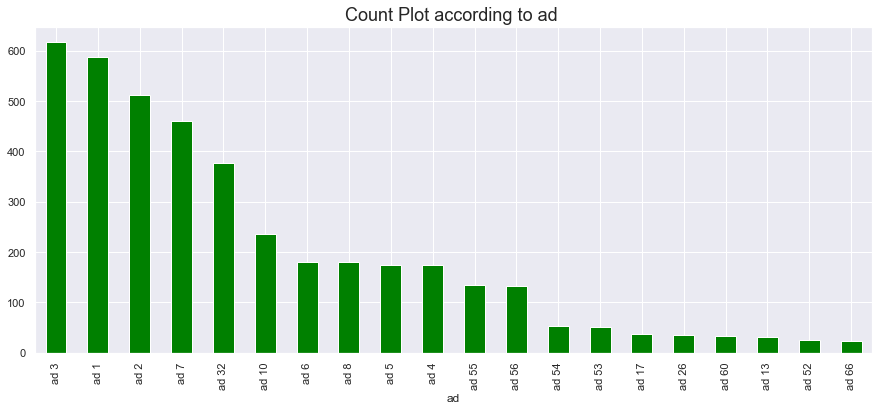

In [8]:
fig = plt.figure(figsize=(15,6))
x_full.groupby('ad').count()['revenue'].sort_values(ascending=False)[0:20].plot(kind='bar',color='green')
plt.title("Count Plot according to ad ",size=18);

##  EDA (Exploaritary Data Analysis) :
Quick EDA using describe method :

to see if there are any missing values and get an idea of deviation of variables

In [9]:
x_full.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
impressions,4571.0,92.635747,198.349737,1.0,6.00,16.00,84.00,3239.00
clicks,4571.0,43.340844,100.164913,0.0,2.00,7.00,38.00,1771.00
cost,4571.0,2.800834,14.361618,0.0,0.04,0.21,1.35,531.25
conversions,4571.0,1.339094,5.223922,0.0,0.00,0.00,1.00,94.00
revenue,4571.0,231.865340,1091.742763,0.0,0.00,0.00,92.60,20515.41


In [10]:
x_full.isnull().sum()

date           0
campaign       0
adgroup        0
ad             0
impressions    0
clicks         0
cost           0
conversions    0
revenue        0
dtype: int64

In [11]:
x_full.dtypes

date            object
campaign        object
adgroup         object
ad              object
impressions      int64
clicks           int64
cost           float64
conversions      int64
revenue        float64
dtype: object

## Preprocessing the Data : 

In [12]:
x_full.head()

,date,campaign,adgroup,ad,impressions,clicks,cost,conversions,revenue
0,01-08-2020,campaign 1,adgroup 1,ad 1,24,6,0.08,0,0.00
1,01-08-2020,campaign 1,adgroup 2,ad 1,1,0,0.00,0,0.00
2,01-08-2020,campaign 1,adgroup 3,ad 1,13,4,0.04,0,0.00
3,01-08-2020,campaign 1,adgroup 4,ad 1,5,4,0.08,0,0.00
4,01-08-2020,campaign 1,adgroup 1,ad 2,247,126,1.29,4,925.71


### separating date into day and year :
 - day and year 

In [13]:
x_full['day']=pd.to_numeric(x_full['date'].apply(lambda x:x.split("-")[0]))
x_full['year']=pd.to_numeric(x_full['date'].apply(lambda x:x.split("-")[2]))

X_test_full['day']=pd.to_numeric(X_test_full['date'].apply(lambda x:x.split("-")[0]))
X_test_full['year']=pd.to_numeric(X_test_full['date'].apply(lambda x:x.split("-")[2]))

x_full.head()

,date,campaign,adgroup,ad,impressions,clicks,cost,conversions,revenue,day,year
0,01-08-2020,campaign 1,adgroup 1,ad 1,24,6,0.08,0,0.00,1,2020
1,01-08-2020,campaign 1,adgroup 2,ad 1,1,0,0.00,0,0.00,1,2020
2,01-08-2020,campaign 1,adgroup 3,ad 1,13,4,0.04,0,0.00,1,2020
3,01-08-2020,campaign 1,adgroup 4,ad 1,5,4,0.08,0,0.00,1,2020
4,01-08-2020,campaign 1,adgroup 1,ad 2,247,126,1.29,4,925.71,1,2020


### revenue variable transformation :

logged to take care of spikes (~3200 zeroes)

nearly 3216 are zeros out of 4571 so to take care spike use log transformation


In [14]:
x_full['revenue'].shape

(4571,)

In [15]:
a = x_full.loc[x_full['revenue']==0]
a.shape

(3216, 11)

In [16]:
x_full.loc[x_full['revenue']==0,'revenue'] = 0.001
x_full['revenue'] = np.log(x_full['revenue'])

x_full.head()

,date,campaign,adgroup,ad,impressions,clicks,cost,conversions,revenue,day,year
0,01-08-2020,campaign 1,adgroup 1,ad 1,24,6,0.08,0,-6.907755,1,2020
1,01-08-2020,campaign 1,adgroup 2,ad 1,1,0,0.00,0,-6.907755,1,2020
2,01-08-2020,campaign 1,adgroup 3,ad 1,13,4,0.04,0,-6.907755,1,2020
3,01-08-2020,campaign 1,adgroup 4,ad 1,5,4,0.08,0,-6.907755,1,2020
4,01-08-2020,campaign 1,adgroup 1,ad 2,247,126,1.29,4,6.830561,1,2020


## Feature Engineering

### Drop clicks and impressions as highly correlated (kept CTR to capture info.)

In [17]:
x_full['CTR'] = x_full['clicks']/x_full['impressions']
x_full['CPA'] = x_full['cost']/x_full['conversions']
x_full.drop(['clicks','impressions'],axis=1,inplace=True)

X_test_full['CTR'] = X_test_full['clicks']/X_test_full['impressions']
X_test_full['CPA'] = X_test_full['cost']/X_test_full['conversions']
X_test_full.drop(['clicks','impressions'],axis=1,inplace=True)

x_full.head()

,date,campaign,adgroup,ad,cost,conversions,revenue,day,year,CTR,CPA
0,01-08-2020,campaign 1,adgroup 1,ad 1,0.08,0,-6.907755,1,2020,0.250000,inf
1,01-08-2020,campaign 1,adgroup 2,ad 1,0.00,0,-6.907755,1,2020,0.000000,NaN
2,01-08-2020,campaign 1,adgroup 3,ad 1,0.04,0,-6.907755,1,2020,0.307692,inf
3,01-08-2020,campaign 1,adgroup 4,ad 1,0.08,0,-6.907755,1,2020,0.800000,inf
4,01-08-2020,campaign 1,adgroup 1,ad 2,1.29,4,6.830561,1,2020,0.510121,0.3225


 **treating nan and inf of CPA : replacing inf with nan and then nan with mean**

In [18]:
x_full['CPA'] = x_full['CPA'].replace(np.inf, np.nan)
x_full['CPA'] = x_full['CPA'].replace(np.nan, x_full['CPA'].mean())

X_test_full['CPA'] = X_test_full['CPA'].replace(np.inf, np.nan)
X_test_full['CPA'] = X_test_full['CPA'].replace(np.nan, X_test_full['CPA'].mean())

x_full.head()

,date,campaign,adgroup,ad,cost,conversions,revenue,day,year,CTR,CPA
0,01-08-2020,campaign 1,adgroup 1,ad 1,0.08,0,-6.907755,1,2020,0.250000,1.873793
1,01-08-2020,campaign 1,adgroup 2,ad 1,0.00,0,-6.907755,1,2020,0.000000,1.873793
2,01-08-2020,campaign 1,adgroup 3,ad 1,0.04,0,-6.907755,1,2020,0.307692,1.873793
3,01-08-2020,campaign 1,adgroup 4,ad 1,0.08,0,-6.907755,1,2020,0.800000,1.873793
4,01-08-2020,campaign 1,adgroup 1,ad 2,1.29,4,6.830561,1,2020,0.510121,0.322500


### Dropping date and campaign variables

In [19]:
x_full.drop(['date','campaign'],axis=1,inplace=True)
X_test_full.drop(['date','campaign'],axis=1,inplace=True)

x_full.head()

,adgroup,ad,cost,conversions,revenue,day,year,CTR,CPA
0,adgroup 1,ad 1,0.08,0,-6.907755,1,2020,0.250000,1.873793
1,adgroup 2,ad 1,0.00,0,-6.907755,1,2020,0.000000,1.873793
2,adgroup 3,ad 1,0.04,0,-6.907755,1,2020,0.307692,1.873793
3,adgroup 4,ad 1,0.08,0,-6.907755,1,2020,0.800000,1.873793
4,adgroup 1,ad 2,1.29,4,6.830561,1,2020,0.510121,0.322500


### converting categorical features into integer features :
with the most common category of the feature :

    being converted to integer 0,
    the next most common to 1, 
    and so on
day,ad,adgroup,year encoded as per frequency :

    as they had levels whose counts varied as per revenue made

In [20]:
def freqencoder(data, col):
    df = data
    val_freq = df[col].value_counts() # counting how many time the col come in this dataframe 
    df[col] = [val_freq.index.tolist().index(i) for i in df[col]]
    return df

x_full = freqencoder(x_full,'adgroup')
x_full = freqencoder(x_full,'ad')
x_full = freqencoder(x_full,'day')
x_full = freqencoder(x_full,'year')

X_test_full = freqencoder(X_test_full,'adgroup')
X_test_full = freqencoder(X_test_full,'ad')
X_test_full = freqencoder(X_test_full,'day')
X_test_full = freqencoder(X_test_full,'year')

x_full.head()

,adgroup,ad,cost,conversions,revenue,day,year,CTR,CPA
0,1,1,0.08,0,-6.907755,2,0,0.250000,1.873793
1,3,1,0.00,0,-6.907755,2,0,0.000000,1.873793
2,0,1,0.04,0,-6.907755,2,0,0.307692,1.873793
3,2,1,0.08,0,-6.907755,2,0,0.800000,1.873793
4,1,2,1.29,4,6.830561,2,0,0.510121,0.322500


**converting all features to float**

In [21]:
x_full = x_full.astype(float)
X_test_full = X_test_full.astype(float)
x_full.head()

,adgroup,ad,cost,conversions,revenue,day,year,CTR,CPA
0,1.0,1.0,0.08,0.0,-6.907755,2.0,0.0,0.250000,1.873793
1,3.0,1.0,0.00,0.0,-6.907755,2.0,0.0,0.000000,1.873793
2,0.0,1.0,0.04,0.0,-6.907755,2.0,0.0,0.307692,1.873793
3,2.0,1.0,0.08,0.0,-6.907755,2.0,0.0,0.800000,1.873793
4,1.0,2.0,1.29,4.0,6.830561,2.0,0.0,0.510121,0.322500


In [22]:
X_test_full.head()

,adgroup,ad,cost,conversions,day,year,CTR,CPA
0,1.0,1.0,0.58,1.0,11.0,0.0,0.404959,0.580000
1,0.0,1.0,0.17,0.0,11.0,0.0,0.545455,0.512474
2,3.0,1.0,0.05,0.0,11.0,0.0,0.600000,0.512474
3,2.0,1.0,0.01,0.0,11.0,0.0,0.500000,0.512474
4,2.0,3.0,0.01,0.0,11.0,0.0,0.333333,0.512474


In [23]:
x_full.shape, X_test_full.shape

((4571, 9), (318, 8))

### Split the data 

In [24]:
X = x_full.drop('revenue',axis=1)
Y = x_full['revenue'] 

In [25]:
x_train , x_valid ,y_train , y_valid = train_test_split(X, Y , test_size = 0.33 , random_state = 0)
print("Shape of x_train ", x_train.shape)
print("Shape of y_train ", y_train.shape)
print("Shape of x_valid ", x_valid.shape)
print("Shape of y_valid ", y_valid.shape)

Shape of x_train  (3062, 8)
Shape of y_train  (3062,)
Shape of x_valid  (1509, 8)
Shape of y_valid  (1509,)


## Model 

### LinearRegression 

In [26]:
# Pipeline for Cross Val Score 
model = LinearRegression() # model 
scaler = MinMaxScaler() # scaler
pipeline = Pipeline([('transformer', scaler), ('estimator', model)]) # making pipeline
cv = KFold(n_splits=6) # takibg 6 folds 
scores_train = cross_val_score(pipeline, x_train, y_train, cv = cv) # cross val score for all 6 folds on train data 

print("Cross-validation scores:{}".format(scores_train))

Cross-validation scores:[0.25341155 0.32547099 0.25071247 0.30230293 0.33553423 0.27619739]


In [27]:
model = LinearRegression()
model.fit(x_train,y_train)
pred_lr = model.predict(x_valid)
print('RSME Error : ',mean_squared_error(y_valid,pred_lr))
print("R square score is :",r2_score(y_valid,pred_lr))

RSME Error :  23.0908024182352
R square score is : 0.306337938828786


In [28]:
predictions = np.exp(model.predict(X_test_full))
predictions = pd.DataFrame(predictions,columns=['revenue'])

predictions.to_csv('submission_linear.csv',index=False,header=True)
result1 = pd.read_csv("submission_linear.csv")
result1

,revenue
0,0.049168
1,0.180609
2,0.001299
3,0.006317
4,0.005702
...,...
313,0.001865
314,0.143173
315,0.032851
316,0.168587


### Decision Tree Regressor

In [29]:
model = DecisionTreeRegressor(random_state=0,max_depth=15)
scaler = MinMaxScaler() # scaler
pipeline = Pipeline([('transformer', scaler), ('estimator', model)]) # making pipeline
cv = KFold(n_splits=6) # takibg 6 folds 
scores_train = cross_val_score(pipeline, x_train, y_train, cv = cv) # cross val score for all 6 folds on train data 

print("Cross-validation scores:{}".format(scores_train))

Cross-validation scores:[0.98493603 0.98691903 0.98456975 0.98556172 0.99458963 0.97511476]


In [30]:
model = DecisionTreeRegressor(random_state=0,max_depth=15)
model.fit(x_train,y_train)
pred_lr = model.predict(x_valid)
print('RSME Error : ',mean_squared_error(y_valid,pred_lr))
print("R square score is :",r2_score(y_valid,pred_lr))

RSME Error :  0.29844591378774127
R square score is : 0.9910344991933826


In [31]:
predictions = np.exp(model.predict(X_test_full))
predictions = pd.DataFrame(predictions,columns=['revenue'])

predictions.to_csv('submission_decision.csv',index=False,header=True)
result2 = pd.read_csv("submission_decision.csv")
result2

,revenue
0,52.000000
1,0.001000
2,0.001000
3,0.001000
4,0.001000
...,...
313,0.001000
314,0.001000
315,0.001000
316,0.001000


### XGBOOST 

In [32]:
model = XGBRegressor()
scaler = MinMaxScaler() # scaler
pipeline = Pipeline([('transformer', scaler), ('estimator', model)]) # making pipeline
cv = KFold(n_splits=6) # takibg 6 folds 
scores_train = cross_val_score(pipeline, x_train, y_train, cv = cv) # cross val score for all 6 folds on train data 

print("Cross-validation scores:{}".format(scores_train))

Cross-validation scores:[0.98649334 0.98615933 0.99097697 0.98756613 0.99320087 0.99432634]


In [33]:
model = XGBRegressor()
model.fit(x_train,y_train)
pred_lr = model.predict(x_valid)
print('RSME Error : ',mean_squared_error(y_valid,pred_lr))
print("R square score is :",r2_score(y_valid,pred_lr))

RSME Error :  0.21688071991083124
R square score is : 0.993484768329972


In [34]:
predictions = np.exp(model.predict(X_test_full))
predictions = pd.DataFrame(predictions,columns=['revenue'])

predictions.to_csv('submission_xgboost.csv',index=False,header=True)
result3 = pd.read_csv("submission_xgboost.csv")
result3

,revenue
0,120.848830
1,0.001185
2,0.001082
3,0.001200
4,0.001163
...,...
313,0.001103
314,0.001103
315,0.001183
316,0.000878


### RandomForestRegressor

In [35]:
model = RandomForestRegressor()
scaler = MinMaxScaler() # scaler
pipeline = Pipeline([('transformer', scaler), ('estimator', model)]) # making pipeline
cv = KFold(n_splits=6) # takibg 6 folds 
scores_train = cross_val_score(pipeline, x_train, y_train, cv = cv) # cross val score for all 6 folds on train data 

print("Cross-validation scores:{}".format(scores_train))

Cross-validation scores:[0.98774569 0.98761334 0.99478724 0.98874577 0.9965413  0.99462874]


In [36]:
model = RandomForestRegressor()
model.fit(x_train,y_train)
pred_lr = model.predict(x_valid)
print('RSME Error : ',mean_squared_error(y_valid,pred_lr))
print("R square score is :",r2_score(y_valid,pred_lr))

RSME Error :  0.14559744248499784
R square score is : 0.9956261623036693


In [37]:
predictions = np.exp(model.predict(X_test_full))
predictions = pd.DataFrame(predictions,columns=['revenue'])

predictions.to_csv('submission_rf.csv',index=False,header=True)
result4 = pd.read_csv("submission_rf.csv")
result4

,revenue
0,135.410366
1,0.001000
2,0.001000
3,0.001000
4,0.001000
...,...
313,0.001000
314,0.001000
315,0.001000
316,0.001000
